# Model Analysis 

This program takes in datasets and models, and computes the loss landscapes over varying amounts of data.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import time
import glob

# Importing our existing funcs
import os
import sys
from pathlib import Path

from minima_volume.dataset_funcs import ( load_models_and_data )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [2]:
# User specifies the model module name
from minima_volume.models import modulo_arithmetic_model_data as model_module
modulus = 97

# MNIST specific initialization parameters
hidden_dims = [250]

# Grab model
model_template = model_module.get_model(N = modulus, hidden_dims=hidden_dims, device=device, seed=0)

# Grab loss and metrics
loss_fn_per_sample = model_module.get_loss_fn_per_sample()

## Loading Model and Datasets

In [3]:
# Get the relative path
target_dir = Path("models_and_data") #current directory

# Lists to store loaded models and additional data
loaded_models, loaded_additional_data, loaded_dataset = load_models_and_data(model_template=model_template, target_dir=target_dir, device="cpu")

# Print dataset information
print(f"Dataset type: {loaded_dataset['dataset_type']}")
print(f"Dataset quantities: {loaded_dataset['dataset_quantities']}")

# Print tensor shapes
print("\nTensor shapes:")
for key in ["x_base_train", "y_base_train", "x_additional", "y_additional", "x_test", "y_test"]:
    if loaded_dataset[key] is not None:
        print(f"  {key}: {loaded_dataset[key].shape}")
    else:
        print(f"  {key}: None")

Looking for models and dataset in: models_and_data
Found 9 model files:
  - model_epoch_1000.pt
  - model_epoch_1500.pt
  - model_epoch_200.pt
  - model_epoch_2000.pt
  - model_epoch_3000.pt
  - model_epoch_400.pt
  - model_epoch_5000.pt
  - model_epoch_600.pt
  - model_epoch_800.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_1000.pt
Successfully loaded: model_epoch_1000.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_1500.pt
Successfully loaded: model_epoch_1500.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_200.pt
Successfully loaded: model_epoch_200.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_2000.pt
Successfully loaded: model_epoch_2000.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_3000.pt
Successfully loaded: model_epoch_3000.pt
✅ Model loaded into provided instance from models_and_data\model_epoch_400.pt
Successfully loaded: model_epoch_400.pt


✅ Dataset loaded from models_and_data\dataset.pt
Dataset type: data
Dataset quantities: [0]

Tensor shapes:
  x_base_train: torch.Size([3104, 194])
  y_base_train: torch.Size([3104, 97])
  x_additional: torch.Size([0, 194])
  y_additional: torch.Size([0, 97])
  x_test: torch.Size([9409, 194])
  y_test: torch.Size([9409, 97])


Selected Model Index: 6 (Epochs: 5000)
Train Loss (first few): [0.01217543 0.01161308 0.01121166 0.0109301  0.01073577]
Test  Loss (first few): [0.01163204 0.01124576 0.01098087 0.01080409 0.01069202]
Train Acc  (first few): [0.0128866  0.0128866  0.0128866  0.01256443 0.0128866 ]
Test  Acc  (first few): [0.01030928 0.00999043 0.01009672 0.00967159 0.00945903]


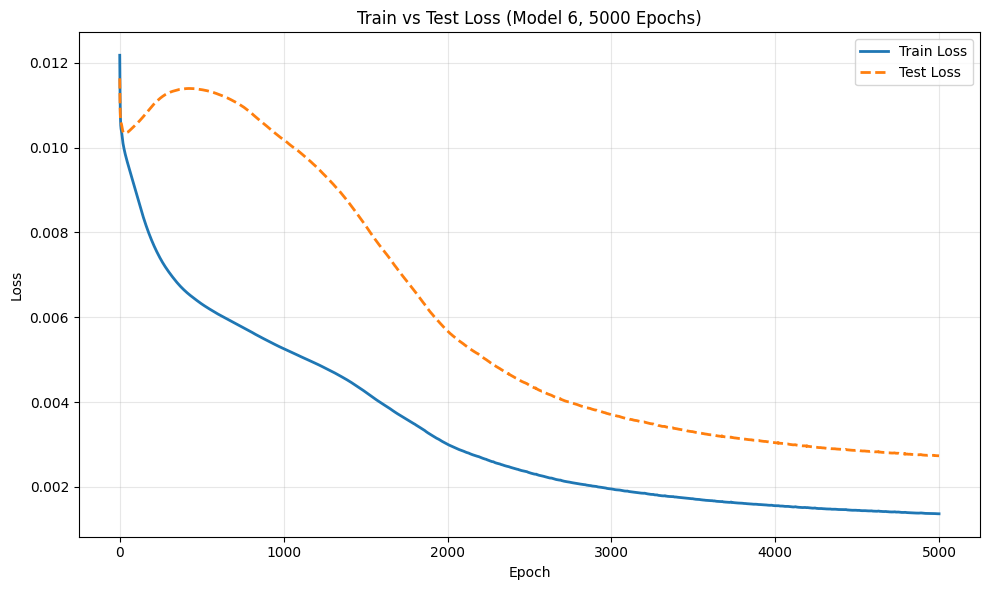

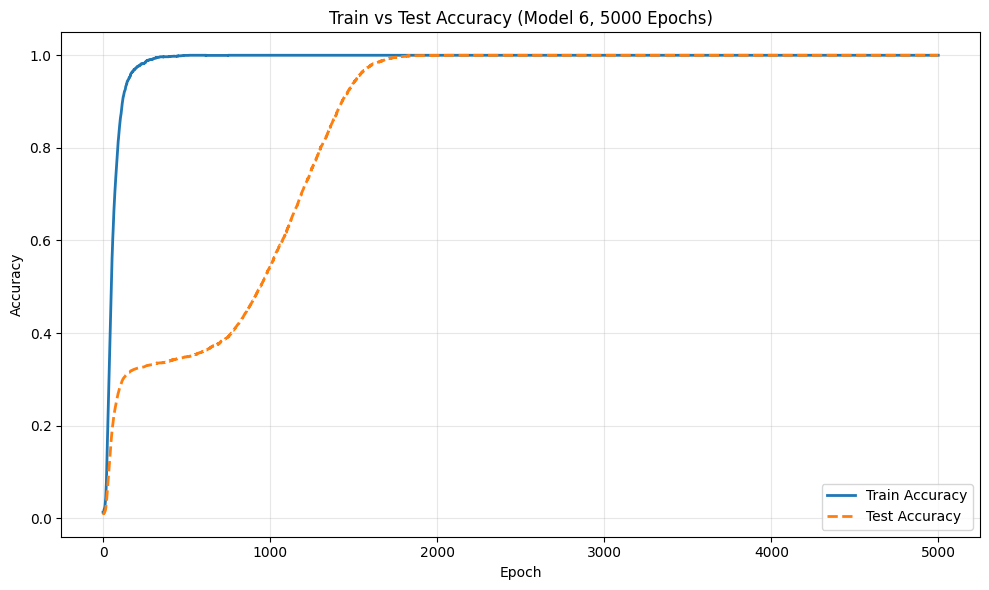


Saved train/test loss and accuracies to losses.npz


In [4]:
# ========================================================
# 1️⃣ Find Model with Longest Training (max len(train_loss))
# ========================================================
max_idx = None
max_len = -1

for idx, model_data in enumerate(loaded_additional_data):
    current_len = len(model_data["train_loss"])
    if current_len > max_len:
        max_len = current_len
        max_idx = idx

# Extract the selected model data
longest_model = loaded_additional_data[max_idx]
train_loss_longest = np.array(longest_model["train_loss"])
test_loss_longest  = np.array(longest_model["test_loss"])
train_acc_longest  = np.array(longest_model["train_accs"])
test_acc_longest   = np.array(longest_model["test_accs"])

print(f"Selected Model Index: {max_idx} (Epochs: {max_len})")
print("Train Loss (first few):", train_loss_longest[:5])
print("Test  Loss (first few):", test_loss_longest[:5])
print("Train Acc  (first few):", train_acc_longest[:5])
print("Test  Acc  (first few):", test_acc_longest[:5])

# ===============================
# 2️⃣ Plot Train vs Test Loss
# ===============================
epochs = np.arange(len(train_loss_longest))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_longest, label="Train Loss", linewidth=2)
plt.plot(epochs, test_loss_longest, label="Test Loss", linewidth=2, linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train vs Test Loss (Model {max_idx}, {max_len} Epochs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# (Optional) Plot Train vs Test Accuracy
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_longest, label="Train Accuracy", linewidth=2)
plt.plot(epochs, test_acc_longest, label="Test Accuracy", linewidth=2, linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Train vs Test Accuracy (Model {max_idx}, {max_len} Epochs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# 3️⃣ Save Data to losses.npz
# ===============================
np.savez("losses.npz",
         train_loss=train_loss_longest,
         test_loss=test_loss_longest,
         train_acc=train_acc_longest,
         test_acc=test_acc_longest)

print("\nSaved train/test loss and accuracies to losses.npz")